# 1D Scattering Matrix: Bragg Grating

This example illustrates the use of the scattering matrix in a simple 1D case, namely an uniform Bragg grating. Although the simulation is quite simple, it constitutes a good starting point, both theoretically and computationally. Indeed, most to the physics and of the computational methods showed here are the same found in more complex simulations. 

The grating in question is built by a periodic repetition of 2 transparent materials (dielectric constant 12.0 and 2.0, respectively). The duty cycle of the grating is 50% and everything is calculated in dimensionless units (or, equivalently, the period of the grating is set to 1).


## Import required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import A_FMM

 ## Transmission and reflection from a finite multilayer <a id='finitegrating'></a>

**Building the structure**

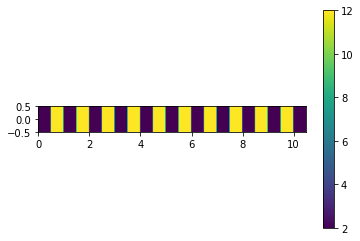

In [2]:
lay1 = A_FMM.Layer_uniform(0,0,2.0)
lay2 = A_FMM.Layer_uniform(0,0,12.0)

mat = 10*[lay1, lay2] + [lay1]
d   = 10*[0.5, 0.5]   + [0.5]

st = A_FMM.Stack(mat, d)
st.count_interface()
st.plot_stack()
plt.show()

**Transmission and reflection at normal incidence**

In [3]:
oml = np.linspace(0.0005, 0.6,1200)
DATA = []
for om in oml:
    st.solve(om)
    T,R = st.get_T(0,0, ordered = False), st.get_R(0,0, ordered = False)
    DATA.append((T,R))
    
DATA = pd.DataFrame(DATA, index = oml, columns = ['T', 'R'])
DATA

,T,R
0.0005,0.996932,0.003068
0.0010,0.987923,0.012077
0.0015,0.973529,0.026471
0.0020,0.954594,0.045406
0.0025,0.932147,0.067853
...,...,...
0.5980,0.089791,0.910209
0.5985,0.074259,0.925741
0.5990,0.061775,0.938225
0.5995,0.051697,0.948303


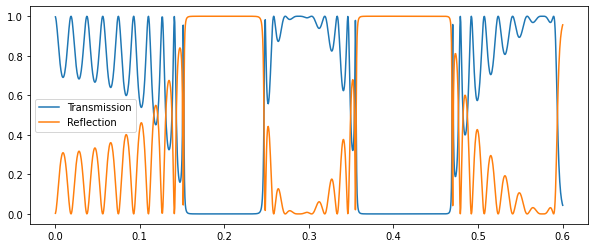

In [4]:
plt.figure(figsize = (10,4))
plt.plot(DATA['T'], label = 'Transmission')
plt.plot(DATA['R'], label = 'Reflection')
plt.legend()

**Transmission and reflection at an angle**

In [5]:
oml = np.linspace(0.002, 0.6,300)
angles = np.linspace(0,90,91)
DATA = []
for om in oml:
    for angle in angles:
        st.solve(om, kx = om*np.sqrt(2.0)*np.sin(np.pi*angle/180.0))
        RE, TE, RM, TM = st.get_R(1,1,ordered=False), st.get_T(1,1,ordered=False), st.get_R(0,0,ordered=False), st.get_T(0,0,ordered=False) 
        DATA.append((om, angle, RE, TE, RM, TM))
        
DATA = pd.DataFrame(DATA, columns = ['om', 'angle', 'R_TE', 'T_TE', 'R_TM', 'T_TM'])  
DATA

/home/marco/Documents/MyPrograms/A_FMM/A_FMM/stack.py:257: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs(self.S.S21[j1,j2])**2*self.layers[0].P_norm[j2]/self.layers[0].P_norm[j1]
/home/marco/Documents/MyPrograms/A_FMM/A_FMM/stack.py:266: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs(self.S.S11[j2,j1])**2*self.layers[-1].P_norm[j2]/self.layers[0].P_norm[j1]


,om,angle,R_TE,T_TE,R_TM,T_TM
0,0.002,0.0,0.045406,9.545935e-01,0.045406,0.954594
1,0.002,1.0,0.045420,9.545802e-01,0.045389,0.954611
2,0.002,2.0,0.045460,9.545401e-01,0.045337,0.954663
3,0.002,3.0,0.045527,9.544732e-01,0.045251,0.954749
4,0.002,4.0,0.045621,9.543794e-01,0.045130,0.954870
...,...,...,...,...,...,...
27295,0.600,86.0,1.000000,7.286253e-12,0.999778,0.000222
27296,0.600,87.0,1.000000,3.555652e-12,0.999899,0.000101
27297,0.600,88.0,1.000000,1.428415e-12,0.999962,0.000038
27298,0.600,89.0,1.000000,3.361567e-13,0.999991,0.000009


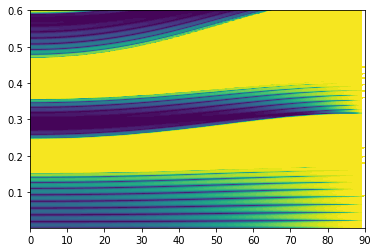

In [6]:
OM, ANG = np.meshgrid(oml, angles, indexing = 'ij')
plt.contourf(angles, oml, DATA.pivot('om', 'angle', 'R_TE'), levels = 41)

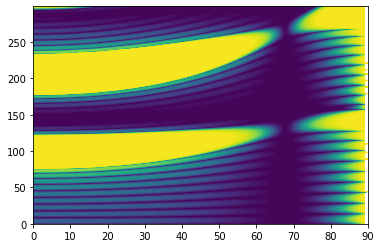

In [7]:
plt.contourf(DATA.pivot('om', 'angle', 'R_TM'), levels = 41)

### Band structure infinite Bragg Grating
A convenient way to make sense of reflection and transmission spectra of a Bragg grating is to look at the band structure. This also can be done with the Aperiodic Fourier Modal Method, since it is possible, given the scattering matrix of the unit cell, to get the Bloch modes by simply solving an eigenvalue problem.

First step is to build the stack object representing the unit cell. In the following the unit cell of the same grating analyzed in the [previos section](#finitegrating). It is worth noting that, due to the way the first and last layer are handled by the code, their thickness will not be included in the unit cell. Thus, first and last layer are irrelevant to the code, but they need to be the same in order for the code to work properly.

Thus, this is how the cell is built:

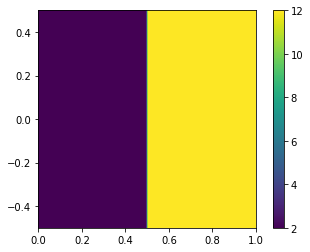

In [8]:
mat = [lay1, lay1, lay2, lay1]
d   = [0.0,0.5, 0.5,0.0]
st = A_FMM.Stack(mat, d)
st.count_interface()
st.plot_stack()
plt.show()

After that, getting the Bloch mode just requires to calculate the scattering matrix by calling `solve` and the solving for the Bloch vector by calling `bloch_modes`, which returns an array containing the found Bloch vectors. In general the Bloch vector is a complex quantity, where the real part represent the evolution of the phase and the imaginary part the evolution of the amplitude. The returned Bloch vectors are ordered by increasing imaginary part. 

In [9]:
DATA = []
for om in oml:
    st.solve(om)
    bm = st.bloch_modes()
    DATA.append([om, bm[0]])
    
DATA = pd.DataFrame(DATA, columns = ['om', 'bk'])
DATA

,om,bk
0,0.002,-0.033248+0.000000j
1,0.004,-0.066497+0.000000j
2,0.006,-0.099748-0.000000j
3,0.008,-0.133002+0.000000j
4,0.010,-0.166262+0.000000j
...,...,...
295,0.592,2.904456+0.000000j
296,0.594,2.974311+0.000000j
297,0.596,3.097148+0.000000j
298,0.598,3.141593+0.147638j


The obtained Bloch vector can then be plotted against the frequency:

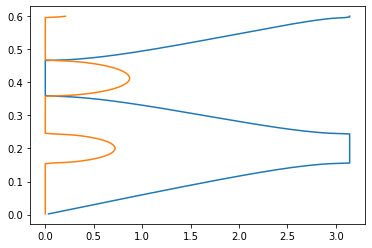

In [10]:
plt.plot(np.abs(np.real(DATA['bk'])), DATA['om'], label='Real')
plt.plot(np.imag(DATA['bk']), DATA['om'], label='Imag')

In addition, the method `plot_E_periodic` is provided for plotting the periodic field. The following, the example are provided: lower band (om=0.1), inside the gap (om=0.16) and the band just above the gap (om=0.26) 

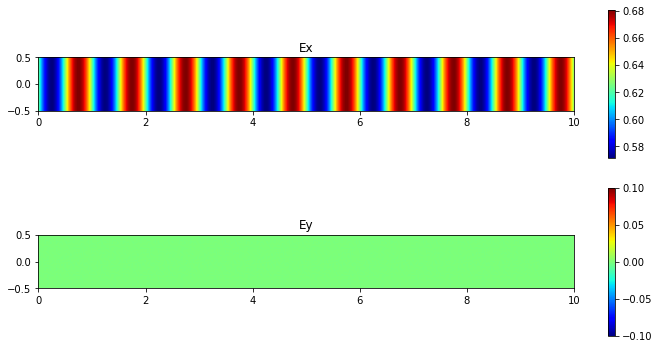

In [11]:
st.solve(0.1)
st.bloch_modes()
st.plot_E_periodic(0, r=10, func = np.abs)

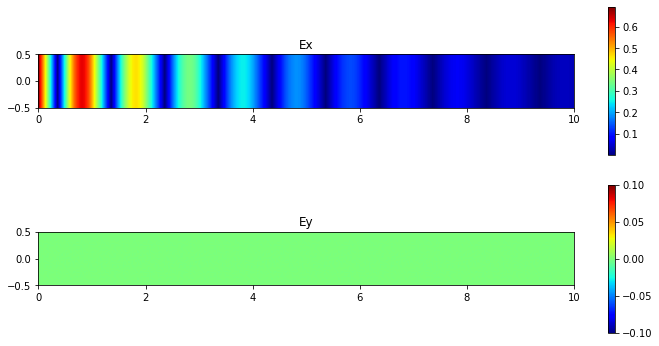

In [12]:
st.solve(0.16)
st.bloch_modes()
st.plot_E_periodic(0, r=10, func = np.abs)

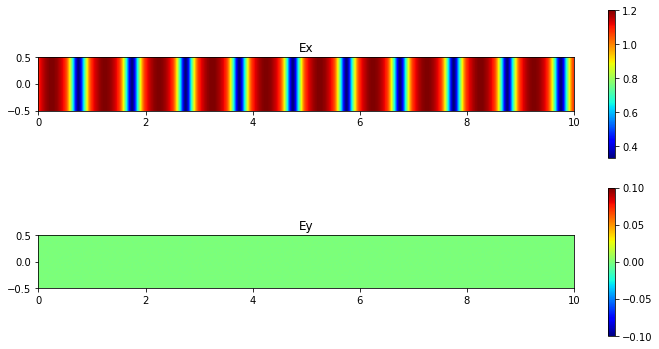

In [13]:
st.solve(0.26)
st.bloch_modes()
st.plot_E_periodic(0, r=10, func = np.abs)